In [1]:
import pydicom

from data_structures.ct_image import CTImage

In [2]:
reference_image_path = "data_2/Project/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
patient_image_path = "data_2/Project/RM_Brain_3D-SPGR/"

In [3]:
reference_image = pydicom.dcmread(reference_image_path)
reference_image.pixel_array.shape

(193, 229, 193)

In [4]:
patient_image = CTImage()
patient_image.load_data(patient_image_path)
patient_image.make_3d_array()

(512, 512)


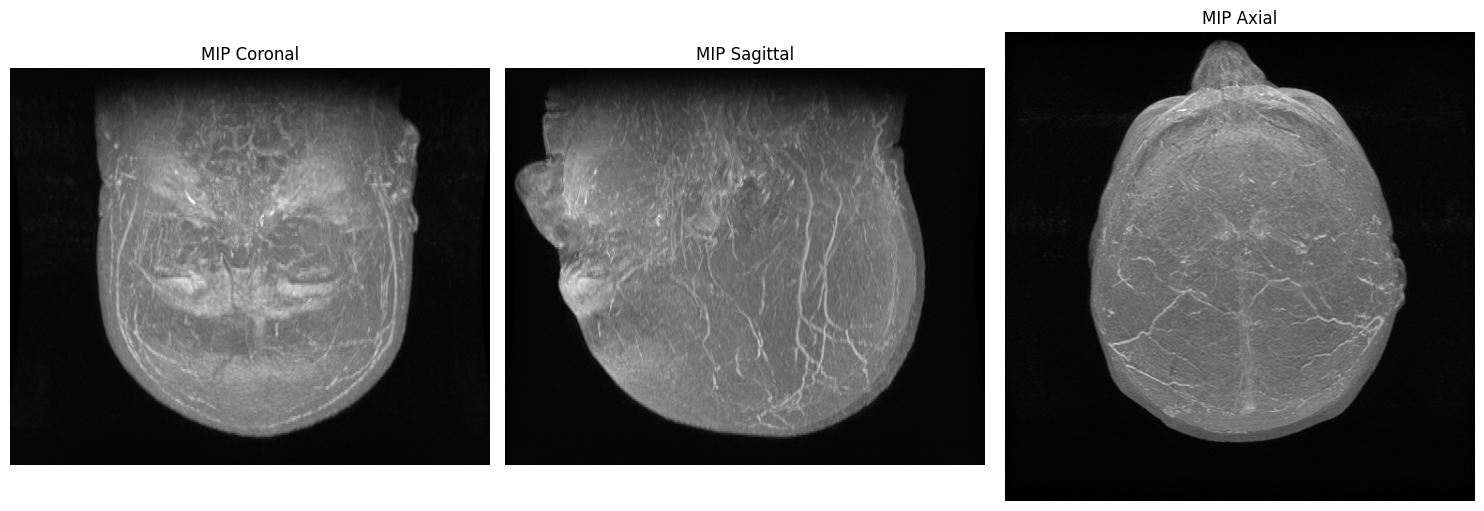

In [6]:
patient_image.visualize_all_projections_mip()

(212, 512, 512)


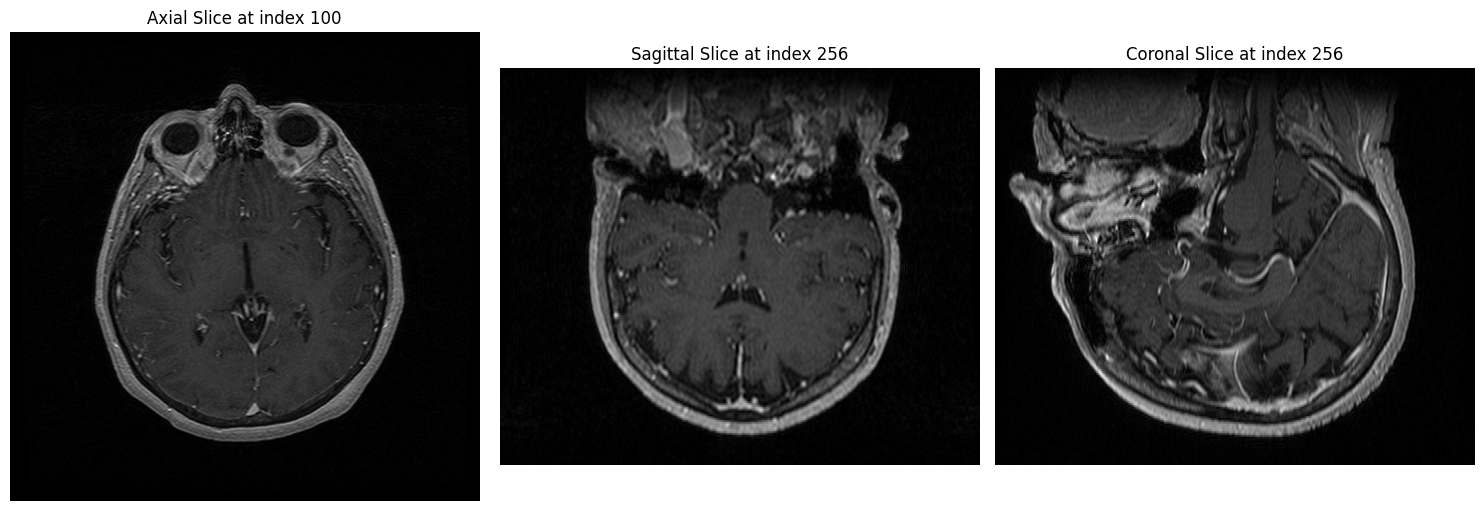

In [10]:
print(patient_image.pixel_array.shape)
patient_image.vislualize_slices(100, 256, 256)